# Sequential Agent

In this notebook implements a simple greedy agent that moves in the direction of the nearest destination based on the `TreeObsForRailEnv`.

In [1]:
import numpy as np
from flatland.envs.observations import TreeObsForRailEnv
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_generators import complex_rail_generator
from flatland.envs.predictions import ShortestPathPredictorForRailEnv
from flatland.envs.schedule_generators import complex_schedule_generator
from flatland.utils.rendertools import RenderTool
from IPython.display import clear_output
import PIL
%matplotlib inline

In [2]:
def render_env(env,wait=True):
    
    env_renderer = RenderTool(env, gl="PILSVG")
    env_renderer.render_env()

    image = env_renderer.get_image()
    pil_image = PIL.Image.fromarray(image)
    clear_output(wait=True)
    display(pil_image)

def min_gt(seq, val):
    """
    Return smallest item in seq for which item > val applies.
    None is returned if seq was empty or all items in seq were >= val.
    """
    min = np.inf
    idx = len(seq) - 1
    while idx >= 0:
        if seq[idx] >= val and seq[idx] < min:
            min = seq[idx]
        idx -= 1
    return min

In [3]:
class OrderedAgent:

    def __init__(self):
        self.action_size = 5

    def act(self, state, eps=0):
        """
        :param state: input is the observation of the agent
        :return: returns an action
        """
        distance = []
        for direction in TreeObsForRailEnv.tree_explored_actions_char:
            try:
                distance.append(state.childs[direction].dist_min_to_target)
            except:
                distance.append(np.inf)
        distance = np.array(distance)
        min_dist = min_gt(distance, 0)
        min_direction = np.where(distance == min_dist)
        if len(min_direction[0]) > 1:
            return min_direction[0][-1] + 1
        return min_direction[0] + 1

In [4]:
np.random.seed(2)
x_dim = 20  # np.random.randint(8, 20)
y_dim = 20  # np.random.randint(8, 20)
n_agents = 3  # np.random.randint(3, 8)
n_goals = n_agents + np.random.randint(0, 3)
min_dist = int(0.75 * min(x_dim, y_dim))

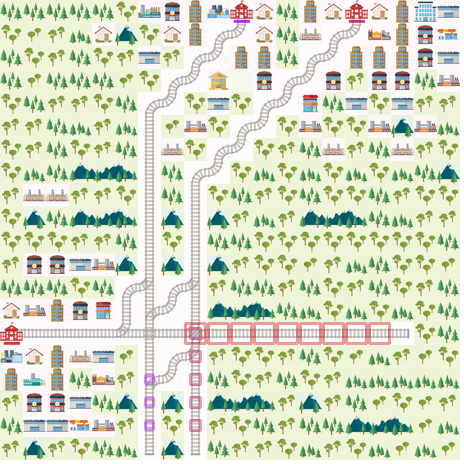

In [5]:
env = RailEnv(width=x_dim,
              height=y_dim,
              rail_generator=complex_rail_generator(nr_start_goal=n_goals, nr_extra=5, min_dist=min_dist, max_dist=99999, seed=0),
              schedule_generator=complex_schedule_generator(),
              obs_builder_object=TreeObsForRailEnv(max_depth=1,
              predictor=ShortestPathPredictorForRailEnv()),
              number_of_agents=n_agents)
env.reset()
render_env(env)

In [6]:
def run_episode(env, agent, render = True):

    env_renderer = RenderTool(env)
    max_steps = 100 * (env.height + env.width)-1
    action_dict = dict()
    # Reset environment
    obs, info = env.reset(regenerate_rail = False,regenerate_schedule = False)
    done = env.dones
    env_renderer.reset()
    frame_step = 0
    score = 0
    # Run episode
    for step in range(max_steps):

        # Action
        acting_agent = 0
        for a in range(env.get_num_agents()):
            if done[a]:
                acting_agent += 1
            if a == acting_agent:
                action = agent.act(obs[a])
            else:
                action = 4
            action_dict.update({a: action})
        # Environment step

        obs, all_rewards, done, _ = env.step(action_dict)
        for agent_handle in env.get_agent_handles():
            score += all_rewards[agent_handle]
        print('Timestep {}, total score = {}'.format(step, score))


        if done['__all__']:
            print('All done')
            break

        # Render
        if render:
            render_env(env)
        else:
            clear_output()

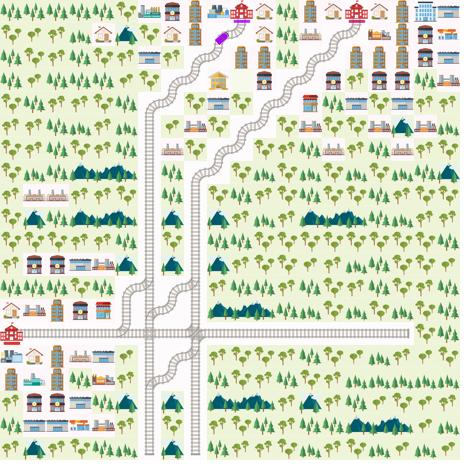

Timestep 68, total score = -126.0
All done


In [7]:
run_episode(env,OrderedAgent())

In [8]:
class RandomController:
    def __init__(self, action_size):
        self.action_size = action_size

    def act(self, observations):
        actions = dict()
        for agent_handle, observation in enumerate(observations):
            action = np.random.randint(self.action_size)
            actions.update({agent_handle: action})
        return actions

random_agent = RandomController(5)
run_episode(env,random_agent,False)


Timestep 599, total score = -1800.0
All done
